# **Clasificación de imágenes de células de sangre para diagnóstico de malaria**
# **Miembros:** Nicole Góngora y Fabian Segurondo
# **Materia:** Certificación Data Science

El objetivo de este proyecto no sólo es la aplicación de los conocimientos del tercer parcial de la materia, sino la experimentación de técnicas aprendidas de manera externa para mejorar un modelo de clasificación de imágenes a partir de un dataset externo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Carga del dataset**


## **Explicación de la base de datos**

[Información completa del dataset en ingles](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-screener.html)

[Dataset en Keras](https://https://www.tensorflow.org/datasets/catalog/malaria)

La información que se va a utilizar es un dataset de imágenes PNG de células para el diagnóstico de malaria a partir del estado de estas células: Infectado (Parasitized) o Sano (Uninfected).

La malaria es una enfermedad causada por parásitos dentro de la saliva de mosquitos, infectada a traves de su picadura en la piel. Su letalidad es grande: 200 milliones de personas sufren la enfermedad y 400 mil resultan fallecidas; con la población infantil de Africa siendo la más afectada: desde fiebre y dolores de cabeza hasta lapsos de coma y epilepsia, la muerte siendo el más probable resultado.

Proporcionado desde el National Library of Medicine (NIH), este dataset de imágenes utiliza el análisis de células sanguíneas por microscopio en luz estandarizado para verificar un buen diagnóstico; todo con el fin de tratar los siguientes problemas de análisis y resultados erróneos:

- Casos falsos negativos: Uso innecesario de antibióticos, consultas sin resultados pertinentes, y avance severo de la malaria

- Casos falsos positivos (falsas alarmas): Uso indebido de medicamentos para la malaria y efectos secundarios de su consumo: nausea, dolor abdominal, diarrea y otras complicaciones


Se utilizó un link externo a la base de datos, descargándolo con get_file() como un archivo comprimido y guardándolo en un directorio temporal de Colab.

Seguidamente, para utilizar la carpeta, se utiliza el comando unzip con formato de comando de SO Python para descomprimir el dataset en una carpeta, pudiendo así tener el acceso a los subdirectorios de células según estado y mostrar algunas de estas con la librería Pillow - Python Imaging Library (PIL)

In [ ]:
import pathlib
dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
data_dir = tf.keras.utils.get_file('cell_images', origin=dataset_url,untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

353452851/353452851 [==============================] - 6s 0us/step


PosixPath('/root/.keras/datasets/cell_images')

In [ ]:
!unzip "/root/.keras/datasets/cell_images.tar.gz" -d "/root/.keras/datasets"

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: /root/.keras/datasets/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting:

In [ ]:
!ls  /root/.keras/datasets/

cell_images  cell_images.tar.gz


## **Analisis del dataset**

Se presentara a continuacion un conteno de las imagenes respectivamente que muestran cuales son infectados y cuales no igualemente.

In [ ]:
for child in data_dir.iterdir():
  print(child)

/root/.keras/datasets/cell_images/Uninfected
/root/.keras/datasets/cell_images/Parasitized


Por el buen orden, realizaremos un conteo final de la cantidad de imagenes con las que iremos a trabajar, dando como resultado el numerop de 27558; demostrando de esta manera que la robustez del modelo y la alta proyeccion que este puede tener para trabajar con cantidades considerables de datos.

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


## **Demostracion de las imagenes**

Se analizara respectivamente celulas que esten infectadas, se pondran como muestra como estan se ven y de la misma manera se veran los tipos de celulas que no han sido infectadas; de esta manera se representara respectivamente cuales son claramente.

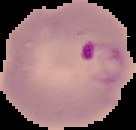

In [ ]:
infectedcells = list(data_dir.glob('Parasitized/*'))
PIL.Image.open(str(infectedcells[0]))

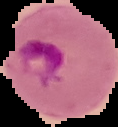

In [ ]:
PIL.Image.open(str(infectedcells[1]))

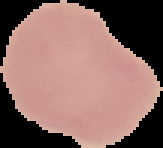

In [ ]:
goodcells = list(data_dir.glob('Uninfected/*'))
PIL.Image.open(str(goodcells[0]))

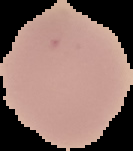

In [ ]:
PIL.Image.open(str(goodcells[1]))

# **Creación de los sets de entrenamiento y prueba, visión de labels y previsualización de las muestras**

Considerando que el tamaño del dataset de las imágenes es muy amplio (27558 filas en total), se utiliza un batch o conjunto de 258 muestras. Se uniformará cada imágen en un rango de 128x128 píxeles, considerando que son muy pequeñas.

Con el comando image_dataset_from_directory(), le damos el directorio de la carpeta descomprimida para que tome las imágenes dentro de ella y las convierta en un set dividido: Uno de entrenamiento (subset "training") y de prueba (subset "validation") en 80/20 ("validation_split"=0.2), con un seed random establecido, el tamaño uniformado de las imágenes, y el tamaño de muestras o batch.

In [ ]:
batch_size = 280
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


De esta manera, una vez identificados los modelos previos de validacion con las propias imagenes y establecido el training, tendremos identificados claramente cuales seran las clases respectivas de parasitado (infectado) y sin infeccion. Pra continuar posteriormente con nuestro entrenamiento.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


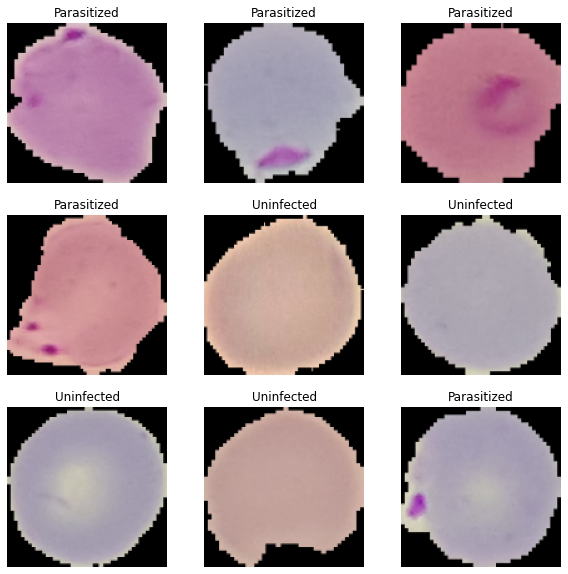

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Se observa con exito cuales son las celulas que estas infectadas y cuales no respectivamente del dataset de entrenamiento, tomando en cuenta los parametros de caracteristicas de la celula establecidos inicialmente y que se comprueba en esta preclasificacion que cumplen con los estandares.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(280, 128, 128, 3)
(280,)


# **Preparación de los sets de entrenamiento y prueba**

## **Optimización del uso de CPU**

Para que el procesamiento del clasificador pueda ser optimizado en el CPU de Colab, se utiliza la librería "data" de Tensorflow para que pueda desarrollar un pipeline (grupo de procesos automatizados para el desarrollo de sistemas) más efectivo y rápido, considerando la cantidad de datos que se deben procesar.

Con la opción AUTOTUNE colocada en el tamaño del buffer, se seleccionará de manera previa (prefetch) los N datos calculados más óptimos para los sets de entrenamiento y validación. Así mismo, en el caso del set de entrenamiento, hará un intercambio de filas en los 1000 primeros elementos.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Normalizacion de capas**

Por el buen orden se procedera a efectuar al modelo de normalizacion de las imagenes, empleando las librerias de rescalamiento y entrenamiento para estandizar las capas de todos los datos con los que vayamos a trabajar. Gracias a la capa Rescaling, se puede establecer los datos en un rango determinado, siendo el más usado el de 0 a 1 mediante una división 1/255 para imágenes con canales RGB. Esta sección será una demostración inicial de este proceso, para verificar que los píxeles de una imágen de muestra estén dentro de este rengo normalizado.

Gracias a este tratamiento, el proceso de creación de modelos de clasificación de imágenes tendrá más chances de tener una eficiencia óptima


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.91960466


# **Creación de los modelos**

Por el buen orden se presentara el desarrollo de los tres modelos de clasificación con los que se tendra que trabajar y concluir los aspectos que se tengan analizados.

Todos tendrán una compilación de optimizador "adam", así como una métrica de errores por pérdidas de tipo Cross-Entropy (para verificar la distancia del valor original contra el predicho en cifras de probabilidad, especialmente en clasificación de objetos), y precisión para la evaluación positiva; esto debido a ser los más indicados y utilizados para la evaluación de imágenes por categorías

## **Primer modelo, sin optimizadores de imágen (MaxPooling2D o Convoluciones)**

Para el primer modelo, se tiene una red neuronal compuesta de las siguientes capas:

- Rescaling: La que fue antes indicada, recibiendo la forma de la imagen como entrada (alto,ancho,canales) para escalar los valores de los píxeles de la imagen en el rango 0 a 1
- Flatten: La conversión de los valores de la imagen de una matriz a un array de tamaño alto x ancho x canales, para un mejor manejo de su composición
- Dense (oculta): La capa oculta densa. Permite efectuar la operación: salida = activación (punto (entrada, núcleo) + sesgo) donde la activación es la función de activación por elementos que se pasa por las capas anteriores, el núcleo es una matriz de pesos creada por la capa y el sesgo es un vector de sesgo creado por la capa (aqui no se requiere). Para esta capa, se aplicaron 128 filtros de salida para un rendimiento mas robusto y formativo en la ejecución del modelo, ademas de una función de activación "relu" para no sólo un mejoramiento y eficiencia del mismo, sino para mantener un descenso de la gradiente óptimo.
- Dense (salida): Para obtener el resultado de la clasificación, se crea una nueva capa densa, con la diferencia de que el número de células de salida es 2, correspondiendo a las dos clases posibles de las imágenes: Sana e Infectada. Su salida será un valor de 0 a 1, indicando así la clase de célula que corresponde cada imagen

In [ ]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Luego de la compilación del modelo, se llama a summary() para obtener un resumen y avance del desarrollo del modelo con la implementacion de las capas respectivas y su estandarización.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6,291,842
Trainable params: 6,291,842
Non-trainable params: 0
_________________________________________________________________


Para analizar este punto, a continuacion realizaremos la ejecucion del fitting del primer modelo, de la siguiente manera:

Los epochs o periodos de ajuste serán 10, considerando el gran tamaño de los sets de entrenamiento y validación y velar por el menor tiempo de cálculo posible. Así mismo, se utilizará el set de validación junto al de entrenamiento, para así obtener mediante la variable "history" el progreso de las pérdidas y precisiones por set; asi verificando no sólo cuán optimos son, sino tambien cuán diferentes son uno del otro

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
79/79 [==============================] - 29s 362ms/step - loss: 3.0969 - accuracy: 0.5750 - val_loss: 0.6218 - val_accuracy: 0.6451
Epoch 2/10
79/79 [==============================] - 23s 296ms/step - loss: 0.6395 - accuracy: 0.6364 - val_loss: 0.6277 - val_accuracy: 0.6543
Epoch 3/10
79/79 [==============================] - 25s 321ms/step - loss: 0.6248 - accuracy: 0.6575 - val_loss: 0.6162 - val_accuracy: 0.6676
Epoch 4/10
79/79 [==============================] - 32s 401ms/step - loss: 0.6449 - accuracy: 0.6503 - val_loss: 0.6213 - val_accuracy: 0.6634
Epoch 5/10
79/79 [==============================] - 25s 318ms/step - loss: 0.6078 - accuracy: 0.6702 - val_loss: 0.6353 - val_accuracy: 0.6496
Epoch 6/10
79/79 [==============================] - 26s 330ms/step - loss: 0.6202 - accuracy: 0.6641 - val_loss: 0.6813 - val_accuracy: 0.6255
Epoch 7/10
79/79 [==============================] - 27s 334ms/step - loss: 0.7207 - accuracy: 0.6320 - val_loss: 1.1466 - val_accuracy: 0.5092

## **Segundo modelo, con optimizadores de imágen (MaxPooling2D y Convoluciones)**

Para el segundo modelo, se tiene una red neuronal compuesta de las mismas capas del anterior, pero con adiciones entre el Rescaling() y Flatten():

- Conv2D: Encargada de la convolución de los datos de una imágen como una matriz de píxeles. Toma porciones o filtros de la matriz, las multiplica por una nueva o filtro/kernel convolucional compuesta de unos y ceros intercalados, y suma los números obtenidos de esa mezcla en una celda nueva, formando un conjunto de datos más pequeño en los que la red neuronal pueda enfocarse: hallarles pesos correspondientes y replicarlos en los demás nodos, ahorrando memoria de procesamiento. Sin embargo, como el tamaño del conjunto resultante es menor al que recibe como entrada, se puede habilitar una función de padding: una generación de celdas o pixeles (siendo imágenes) con valores de 0 a los rincones finales de la matriz de la imagen, de tal manera que no sólo el tamaño de la imagen convolucionada sea igual a la original, sino que intente mantener la integridad de la entrada.
Para este ejemplo, se utilizan 3 capas de convolución con filtros de salida en el siguiente orden 16-32-64, correspondiendo a los canales de la imágen que se deben evaluar. Así mismo, el tamaño del filtro que cambiará los valores de la nueva matriz a devolver será de 3x3, y para obtener la salida en el mismo tamaño que se la entregó, se aplicó el padding con el valor "same". Como toda capa oculta con activación, se le configuró el método relu.
- MaxPooling2D: Está encargada de reducir una matriz de información, preferentemente creada por una operación de convolución, a un tamaño menor: la nueva estructura está formada por celdas de cifras, todas creadas por un filtro o “pool” de imágenes en un rango empezando de 2x2 por defecto, por el que se toma porciones de la matriz y se escoge al valor máximo de cada una. Si bien su movimiento es siempre de 1 celda a otra, se puede modificar este movimiento con “strides” para indicarle cuantas celdas debe moverse horizontal y verticalmente. Si bien puede implementársele la función de padding a la matriz resultado para no perder píxeles, no es el propósito general de esta capa.
Para este ejemplo, luego de cada convolución, se aplica una capa de MaxPooling2D para reducir el rango de píxeles a evaluar en forma de una matriz encogida a la mitad de su tamaño con nuevos valores, y sin padding o método de activación ya que se quiere que este método reduzca el tamaño sin pre-requisitos.

In [ ]:
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Luego de la compilación del modelo, se llama a summary() para obtener un resumen de la red neuronal desarrollada. Como se puede observar, se tiene un número menor de parámetros totales que en el anterior modelo, esto debido a la reducción de pixeles a analizar por las convoluciones y los MaxPooling2D aplicados


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

Para analizar este punto del segundo modelo, a continuacion realizaremos la ejecucion del fitting de la misma manera que en el modelo anterior, con el mismo número de epochs o etapas de ajuste y parámetros indicados

In [ ]:
epochs=10
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
79/79 [==============================] - 385s 5s/step - loss: 0.6703 - accuracy: 0.6040 - val_loss: 0.5940 - val_accuracy: 0.7077
Epoch 2/10
79/79 [==============================] - 391s 5s/step - loss: 0.5760 - accuracy: 0.7109 - val_loss: 0.5238 - val_accuracy: 0.7665
Epoch 3/10
79/79 [==============================] - 401s 5s/step - loss: 0.4246 - accuracy: 0.8315 - val_loss: 0.3262 - val_accuracy: 0.8750
Epoch 4/10
79/79 [==============================] - 395s 5s/step - loss: 0.3007 - accuracy: 0.8991 - val_loss: 0.3019 - val_accuracy: 0.8831
Epoch 5/10
79/79 [==============================] - 381s 5s/step - loss: 0.2232 - accuracy: 0.9257 - val_loss: 0.1934 - val_accuracy: 0.9294
Epoch 6/10
79/79 [==============================] - 363s 5s/step - loss: 0.1625 - accuracy: 0.9431 - val_loss: 0.1687 - val_accuracy: 0.9452
Epoch 7/10
79/79 [==============================] - 343s 4s/step - loss: 0.1363 - accuracy: 0.9523 - val_loss: 0.1671 - val_accuracy: 0.9379
Epoch 8/10
79

## **Tercer modelo, con optimizadores de imágen (MaxPooling2D y Convoluciones) y de información (Data Augmentation y Dropout)**

Aun si el número de imágenes en el set de entrenamiento es mayor al de prueba, existe la probabilidad de que el modelo tome en cuenta demasiado los detalles extremos no deseados del primer grupo, hasta el punto de afectar negativamente el rendimiento ante entradas nuevas o de validación. Este fenómeno se llama overfitting: significando que la red neuronal tendrá dificultades para generalizar en un nuevo conjunto de datos de manera exitosa.

Para regularizar este problema de manera efectiva, se utilizan dos técnicas en la nueva red neuronal, basada en la segunda:

### **Data Augmentation**

Data Augmentation es una metodología de regularización que consiste en la generación de datos adicionales a partir de la información existente mediante transformaciones randómicas aplicadas en ella: En el caso de las imágenes, siendo el trabajo enfocado a estas, incluye la rotación, cambio vista en escala o zoom, cambio de orientación (horizontal y/o vertical), entre otros. Estas alteraciones se guardan como información extra, para así tener una mayor diversidad de datos a tomar en cuenta en el aprendizaje y tener una precisión más alta de información en la evaluación al revisar distintos enfoques (posición, rotación iluminación, etc) de una misma clase, lo cual sucede en la toma de fotografías en un entorno realista.

En el modelo nuevo a diseñar para reducir el overfitting generado en la primera evaluación de precisiones y pérdidas, se estableció un nuevo modelo de clase Secuencial, consistente de cinco capas de preprocesamiento de imágenes que cumplen con las características del Data Augmentation de la información existente:

-	La capa de cambio aleatorio de orientación de imagen o RandomFlip, habilitada para cambiar el factor de manera horizontal y vertical

-	La capa de rotación aleatoria de imagen o RandomRotation, con el factor de 30% para un rango de rotación de imagen entre -0.30/2pi a 0.30/2pi grados.

-	La capa de aumento randómico de enfoque de imagen o RandomZoom, con el factor de zoom equitativo del 25% considerando que son células e imágenes pequeñas.

-	La capa de brillo randómico de imagen o RandomBrightness, con un factor de cambio del 15% que altera el brillo de la información del -15 al 15%, y un rango de 0 a 1 de entrada considerando la normalización antes realizada

-	La capa de contraste randómico de imagen o RandomContrast, con un factor de cambio del 15% que altera el contraste de la información del -15 al 15%.

Para el cambio de orientación, al tener células con objetos o manchas que indican presencia de la malaria, un cambio vertical u horizontal sería demasiado repetitivo, y más considerando la cantidad grande de datos del dataset de imágenes. Por lo tanto, en vez de realizar un solo tipo de orientación, se aplicaron los dos, variando más las imágenes disponibles.

Para la rotación y zoom, se han seleccionado valores un poco más altos de cambio de sus factores, pero no a un extremo de valores del 50% o más: Esto es debido a que, si bien son unidades microscópicas las imágenes a evaluar o células, se quiere ver el nivel de distribución del coloramiento de cada una, así como de las manchas que indican una parasitación; pero no al punto de enfocar el zoom tan alto que sólo muestre el centro o que no parezca un cambio, o que la rotación alta devuelva un valor de imagen similar a una con orientación cambiada, esto de manera accidental.

Para el caso del contraste y brillo randómico de imagen, se ha seleccionado un factor del 15% para la alteración: Este valor es el indicado ya que, si bien se quiere simular una variedad de calidad de toma de imágenes de células por parte del microscopio, un valor alto como 20 o más podría distorsionar la imagen demasiado al punto de que detalles como una coloración suave puedan ser malinterpretados como una infección, entre otras equivocaciones. Así mismo, un valor menor de rango de brillo y contraste podría dar variaciones no tan notables en la información, lo cual técnicamente generaría copias de las imágenes que deberían supuestamente ser variadas para el aumento de información y variación.



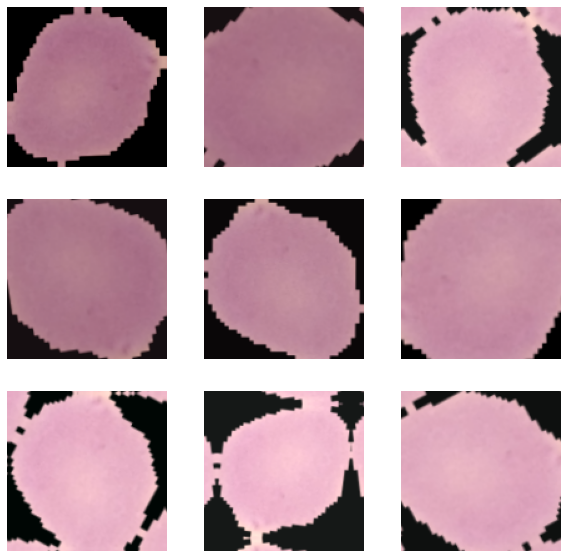

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.25),
    layers.RandomBrightness(0.15),
    layers.RandomContrast(0.15)
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Al revisar el resultado de la operación de Data Augmentation con las imágenes del conjunto de entrenamiento y validación de imágenes, se aprecian cambios de orientaciones verticales y horizontales en la muestra de célula, junto a un aumento de enfoque o zoom y un alejamiento que es notorio por los pixeles rosados que conforman el borde de la célula. Así mismo, se observa una rotación circular a partir de la posición de los píxeles del borde; e incluso un cambio de contraste y brillo de la muestra al ser las imágenes más claras o más oscuras y/o descoloridas

### **Dropout**
Dropout o “abandono” es una operación de regularización que consiste en la eliminación de una cantidad de células o nodos resultantes de la red neuronal mediante su desconexión de las capas por elección aleatoria, para así reducir el nivel y probabilidades de overfitting ocurriendo en la evaluación del modelo con datos nuevos al variar el nivel de responsabilidad de procesamiento en las células que queden en la red.

En el modelo nuevo diseñado para reducir el overfitting generado en la primera evaluación de precisiones y pérdidas, se estableció la desconexión del 35% aleatorio de las unidades o células de la red neuronal diseñada antes de la primera capa Dense, potenciando las probabilidades de que exista una reducción de pérdidas más efectiva y un nivel de precisión más equilibrado entre los datos de validación y entrenamiento.


In [ ]:
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.35),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


79/79 [==============================] - 421s 5s/step - loss: 0.6513 - accuracy: 0.6214 - val_loss: 0.5342 - val_accuracy: 0.7307
Epoch 2/15
79/79 [==============================] - 409s 5s/step - loss: 0.3213 - accuracy: 0.8681 - val_loss: 0.2027 - val_accuracy: 0.9209
Epoch 3/15
79/79 [==============================] - 496s 6s/step - loss: 0.2227 - accuracy: 0.9178 - val_loss: 0.1715 - val_accuracy: 0.9367
Epoch 4/15
79/79 [==============================] - 485s 6s/step - loss: 0.1943 - accuracy: 0.9354 - val_loss: 0.1481 - val_accuracy: 0.9485
Epoch 5/15
79/79 [==============================] - 471s 6s/step - loss: 0.1878 - accuracy: 0.9380 - val_loss: 0.1459 - val_accuracy: 0.9530
Epoch 6/15
79/79 [==============================] - 489s 6s/step - loss: 0.1719 - accuracy: 0.9426 - val_loss: 0.1533 - val_accuracy: 0.9517
Epoch 7/15
79/79 [==============================] - 478s 6s/step - loss: 0.1712 - accuracy: 0.9433 - val_loss: 0.1459 - val_accuracy: 0.9512
Epoch 8/15
79/79 [======

# **Evaluación de los modelos**

Para evaluar la confidencia y nivel de evaluación de los modelos en la predicción, se utilizarán estas dos imágenes:

- Una célula infectada de malaria

![picture](https://1.bp.blogspot.com/-kYCBBZO_iQk/XvceVmQjetI/AAAAAAAAEro/y5g7DDtTd6g3CNwTfR0sQDxEkuJxivDeQCNcBGAsYHQ/s1600/Malaria_cell_img1.png)

- Una célula sana

![picture](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu5vYKCcrRh6OMq_WPHgQuehJXGjtIDaCH8yJdn8ernuqFqjdfDToodfO4U8tDP_mw3V0&usqp=CAU)

## **Primer modelo: Sin optimizaciones de imagen o de datos**

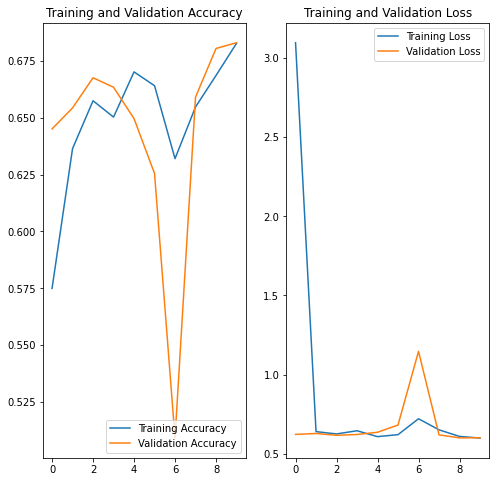

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=10
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Se puede observar con la gráfica anterior, basada en los resultados de métricas de la variable history con respecto al ajuste del modelo, que la precisión de la red neuronal no llega a más del 67,5%, y el rating de errores no baja del 0.6. Si bien el nivel de métrica de evaluación positiva pasa por los 60%, es demasiado bajo.

Este fenómeno puede deberse a que, si bien ha recibido una cantidad amplia de imágenes de entrenamiento y un número de epochs considerable, tiene problemas generalizando e identificando mejor las clases de las células: esto debido a la falta de exploración y conjunción de la información de las imágenes con otros métodos (Convoluciones y Filtros de pixeles) para así tener un mejor conocimiento.

In [ ]:
cell_url = "https://1.bp.blogspot.com/-kYCBBZO_iQk/XvceVmQjetI/AAAAAAAAEro/y5g7DDtTd6g3CNwTfR0sQDxEkuJxivDeQCNcBGAsYHQ/s1600/Malaria_cell_img1.png"
cell_path = tf.keras.utils.get_file('infectedcell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 45ms/step
This cell most likely be Parasitized with a 53.37 percent confidence.


In [ ]:
cell_url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu5vYKCcrRh6OMq_WPHgQuehJXGjtIDaCH8yJdn8ernuqFqjdfDToodfO4U8tDP_mw3V0&usqp=CAU"
cell_path = tf.keras.utils.get_file('sanecell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 26ms/step
This cell most likely be Uninfected with a 62.85 percent confidence.


Así mismo, a partir de las predicciones realizadas con las imágenes planteadas en el principio, se puede ver que, si bien la clasificación de cada célula es la correcta, su nivel de confidencia o probabilidad de acertar correctamente es 53.37% en la celula Infectada, y 62.85% en la celula Sana; indicando una falta de procesamiento de información para que la precisión en la que la categorización se realice sea la más óptima, en este caso, cercano al 100%

## **Segundo modelo: Con optimizaciones de imagen, de manera estándar**

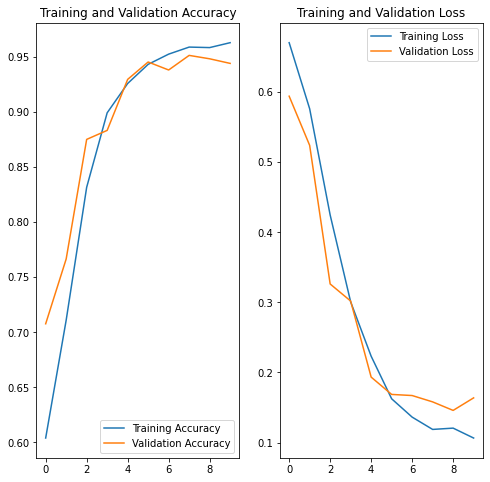

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Se puede observar con la gráfica anterior, basada en los resultados de métricas de la variable history con respecto al ajuste del segundo modelo, que la precisión de la red neuronal ha aumentado al 95%, y el rating de errores baja al 0.1. Si bien los valores son más óptimos que la red neuronal sin procesamientos previos de la entrada, se nota que hay una pequeña descoordinación en el progreso de estas métricas del grupo de entrenamiento contra el de validación: este último con un valor menor de precisión y mayor de error que el primero. Este fenómeno, aun en menor grado, se conoce como overfitting.

Este evento puede provocarse porque, si bien ha recibido una cantidad amplia de imágenes de entrenamiento y un número de epochs considerable junto a una generalización de imagenes con las convoluciones y poolings para identificar valores comunes en las matrices de entrada, tiene valores extremos o indeseados generados dentro del proceso que han sido tomados en cuenta en el set de entrenamiento, perjudicando en algunos epochs al set de pruebas. Para el tercer modelo, se piensa reducir el grado de este problema lo más bajo posible, optimizando la predicción y generalización de nuevas entradas

In [ ]:
cell_url = "https://1.bp.blogspot.com/-kYCBBZO_iQk/XvceVmQjetI/AAAAAAAAEro/y5g7DDtTd6g3CNwTfR0sQDxEkuJxivDeQCNcBGAsYHQ/s1600/Malaria_cell_img1.png"
cell_path = tf.keras.utils.get_file('infectedcell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
This cell most likely be Parasitized with a 99.95 percent confidence.


In [ ]:
cell_url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu5vYKCcrRh6OMq_WPHgQuehJXGjtIDaCH8yJdn8ernuqFqjdfDToodfO4U8tDP_mw3V0&usqp=CAU"
cell_path = tf.keras.utils.get_file('sanecell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
This cell most likely be Uninfected with a 98.85 percent confidence.


Así mismo, a partir de las predicciones realizadas con las imágenes planteadas en el principio, se puede ver que tanto la clasificación de cada célula es la correcta y su nivel de confidencia o probabilidad de acertar correctamente es mayor que en el anterior modelo: 99.95% en la celula Infectada, y 98.85% en la celula Sana.

Estos valores están cercanos a 100, lo cual es muy prometedor. Habrá que ver si el tercer modelo logra aumentar o ajustar de la manera más optima posible la predicción de categorías.

## **Tercer modelo: Con optimizaciones de imagen y de datos para controlar el overfitting**

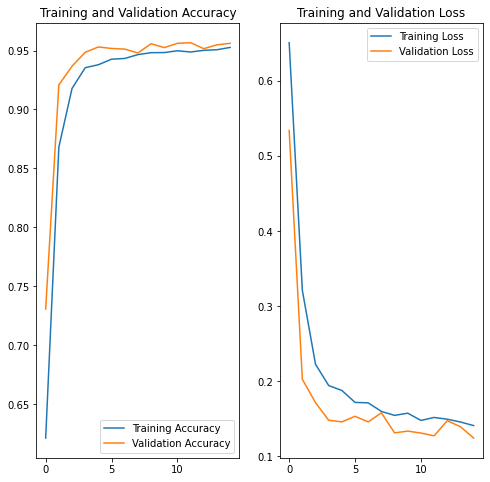

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs=15
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Se puede observar con la gráfica anterior, basada en los resultados de métricas de la variable history con respecto al ajuste del tercer modelo, que la precisión de la red neuronal se mantuvo al 95%, y el rating de errores está en un rango del 0.2 al 0.1. Si bien los valores no tienen una variación enorme de niveles óptimos en comparación con el segundo modelo, se puede observar que el set de validación ya no presenta bajas de evaluación durante los 15 epochs, incluso superando en valores al set de entrenamiento. Esto puede ser visto como algo positivo, ya que indica que hay mas posibilidades de que nuevas imágenes puedan ser mejor clasificadas, y que los datos de entrenamiento no son 100% reglamentarios en ellas; desvaneciendo el overfitting.

Este evento puede provocarse porque, si bien ha recibido una cantidad amplia de imágenes de entrenamiento y un número de epochs considerable junto a una generalización de imagenes con las convoluciones y poolings para identificar valores comunes en las matrices de entrada, el descarte de células de la red neuronal ha logrado reducir los errores que hayan sido probablemente provocados por estas, y el aumento de información con la edición de las imágenes ya existentes ha logrado dar mejores acercamientos desde distintos puntos de vista (ubicación de señales de infección).

Hasta ahora, esto califica al tercer modelo como el mejor para la clasificación de las imágenes de células

In [ ]:
cell_url = "https://1.bp.blogspot.com/-kYCBBZO_iQk/XvceVmQjetI/AAAAAAAAEro/y5g7DDtTd6g3CNwTfR0sQDxEkuJxivDeQCNcBGAsYHQ/s1600/Malaria_cell_img1.png"
cell_path = tf.keras.utils.get_file('infectedcell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 41ms/step
This cell most likely be Parasitized with a 99.98 percent confidence.


In [ ]:
cell_url="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu5vYKCcrRh6OMq_WPHgQuehJXGjtIDaCH8yJdn8ernuqFqjdfDToodfO4U8tDP_mw3V0&usqp=CAU"
cell_path = tf.keras.utils.get_file('sanecell', origin=cell_url)

img = tf.keras.utils.load_img(
    cell_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This cell most likely be {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 55ms/step
This cell most likely be Uninfected with a 99.83 percent confidence.


Así mismo, a partir de las predicciones realizadas con las imágenes planteadas en el principio, se puede ver que tanto la clasificación de cada célula es la correcta y su nivel de confidencia o probabilidad de acertar correctamente ha subido aunque sea en una proporción minúscula: 99.98% en la celula Infectada, y 99.83% en la celula Sana.

Estos valores siguen cercanos a 100, lo cual es muy prometedor; confirmando la mejora de confidencia de la información y rendimiento general del tercer modelo a partir de la implementación de las técnicas Data Augmentation y Dropout para reducir el overfitting

Por lo tanto, la mejor red neuronal para la clasificación de imagenes de células con o sin indicios de infección de malaria es la tercera:

- Tiene una precisión alta, y un nivel bajo de errores; estos más uniformados en los sets de entrenamiento y prueba
- Tiene mejores probabilidades de acertar con nuevas muestras de imágenes, esto proyectado en el rendimiento del set de validación.
- Su confidencia, es decir, el nivel de acertar la clasificación de una célula con respecto a otra es la más alta de todos los modelos

# **Conclusiones finales**

La identificación de infecciones mediante un análisis de células del cuerpo humano ha sido uno de los avances más beneficiosos para la humanidad: Gracias al estudio de los detalles en estas estructuras orgánicas que ayuden a detectar un diagnóstico positivo o negativo de una enfermedad, se pueden desarrollar sistemas automáticos de detección del estado de salud de una persona, parecidos a aquellos dispositivos implementados en las entradas a establecimientos para la detección de temperatura ante el COVID-19: Con sólo una muestra rápida de la sangre (como en este caso) de una persona, una IA entrenada puede dar diagnósticos aproximados que indiquen cuán probable es que el cuerpo tenga alguna enfermedad en desarrollo: desde malaria hasta incluso cancer o diabetes

Con este proyecto, no sólo hemos podido aplicar los conocimientos del curso en este parcial, sino que ademas hemos logrado experimentar con métodos óptimos, aprendidos de manera externa, para la preparación y generalización de imágenes en una red neuronal; pudiendo así crear una red neuronal artificial que logre categorizar e identificar imágenes según sus contenidos. Con nuestra base, podemos permitir nuevos procedimientos de aplicación externa a futuro, agregando conexiones de la información de las imágenes a datos de personas reales simuladas, una revisión de su historial clínico, entre otros, llegando a tener un sistema que ayude al diagnóstico preventivo de enfermedades.